In [1]:
from google.cloud import bigquery
import pandas as pd
from google.oauth2 import service_account
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
credentials = service_account.Credentials.from_service_account_file('C:\\Users\\elija\\Documents\\24f-coop\\credentials.json')
project = 'net-data-viz-handbook'
# Initialize a GCS client
client = bigquery.Client(credentials=credentials, project=project)

## Custom NetSI theme

In [3]:
pip show plotly

Name: plotly
Version: 5.24.1
Summary: An open-source, interactive data visualization library for Python
Home-page: https://plotly.com/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: C:\Users\elija\Documents\24f-coop\demovenv\Lib\site-packages
Requires: packaging, tenacity
Required-by: epidemic-intelligence
Note: you may need to restart the kernel to use updated packages.


In [4]:
# copying plotly default to make 'netsi' theme
pio.templates['netsi']  = pio.templates['plotly_white']

# customize title
pio.templates['netsi']['layout']['title'] = dict(x=.5, y=.95, yref='container', 
                                                 font=dict(color='black', size=28, weight=400),
                                                 subtitle=dict(font=dict(color='#373737', size=14, weight=200))
                                                )

# font
pio.templates['netsi']['layout']['font'] = dict(family=r"PT Sans Narrow",
                                                size=14, color='black')

# custom colors
sequential_color_ls = ['#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
pio.templates['netsi']['layout']['colorscale']['sequential'] = \
[[(a/(len(sequential_color_ls)-1)), color] for a, color in enumerate(sequential_color_ls)]

diverging_color_ls = ['#003f5c', '#577187', '#9ca8b4', '#e2e2e2', '#d0a2af', '#b8637e', '#9a1050']
pio.templates['netsi']['layout']['colorscale']['diverging'] = \
[[(a/(len(diverging_color_ls)-1)), color] for a, color in enumerate(diverging_color_ls)]

pio.templates['netsi']['layout']['shapedefaults']['line']['color'] = '#428299'

# colorway from nicole
pio.templates['netsi']['layout']['colorway'] = ['#428299', '#67C4D3', '#F48A64', '#77C6B1', 
                                                '#F2D65F', '#80A4CE', '#CC9EB1', '#BFD88F', '#8E8E8E']

In [5]:
pio.templates['netsi']['layout']

Layout({
    'annotationdefaults': {'arrowcolor': '#2a3f5f', 'arrowhead': 0, 'arrowwidth': 1},
    'autotypenumbers': 'strict',
    'coloraxis': {'colorbar': {'outlinewidth': 0, 'ticks': ''}},
    'colorscale': {'diverging': [[0.0, '#003f5c'], [0.16666666666666666,
                                 '#577187'], [0.3333333333333333, '#9ca8b4'], [0.5,
                                 '#e2e2e2'], [0.6666666666666666, '#d0a2af'],
                                 [0.8333333333333334, '#b8637e'], [1.0, '#9a1050']],
                   'sequential': [[0.0, '#003f5c'], [0.14285714285714285,
                                  '#2f4b7c'], [0.2857142857142857, '#665191'],
                                  [0.42857142857142855, '#a05195'],
                                  [0.5714285714285714, '#d45087'],
                                  [0.7142857142857143, '#f95d6a'],
                                  [0.8571428571428571, '#ff7c43'], [1.0,
                                  '#ffa600']],
            

## Area Plot

In [6]:
def build_geographic_filter(geo_level, geo_values, alias="g_target"):
    # Accepts a geographic level (e.g., 'country_id', 'region_label') and a list of values
    if geo_values is not None:  # Only filter if geo_values is provided
        if isinstance(geo_values, list):
            # Check the type of the first item to determine the filter type
            if isinstance(geo_values[0], int):
                values = ', '.join(str(val) for val in geo_values)  # For INT64
                return f"{alias}.{geo_level} IN ({values})"
            elif isinstance(geo_values[0], str):
                values = ', '.join(f"'{val}'" for val in geo_values)  # For STRING
                return f"{alias}.{geo_level} IN ({values})"
        else:
            # Handle single values
            if isinstance(geo_values, int):
                return f"{alias}.{geo_level} = {geo_values}"
            elif isinstance(geo_values, str):
                return f"{alias}.{geo_level} = '{geo_values}'"
    return ""  # Return empty string if no filtering is needed

In [7]:
def build_ap_query(table_name, reference_table_name, source_geo_level, target_geo_level, output_geo_level=None, source_values=None, target_values=None, domestic=True, cutoff=0.05):
    # Build filters for both source and target regions
    source_filter = build_geographic_filter(source_geo_level, source_values, alias="g_source") if source_values is not None else 'TRUE'
    target_filter = build_geographic_filter(target_geo_level, target_values, alias="g_target") if target_values is not None else 'TRUE'
    
    # Create the base where clause
    where_clauses = [target_filter, source_filter]
    
    if not domestic:
        # Exclude rows where target imports to itself
        where_clauses.append(f"g_source.{target_geo_level} <> g_target.{target_geo_level}")

    # Join the where clauses with 'AND'
    where_clause = ' AND '.join(where_clauses)

    query = f"""
    WITH region_imports AS (
      SELECT 
        g_source.{output_geo_level} AS source_label, 
        SUM(i.importations) AS total_importations
      FROM 
        `{table_name}` AS i
      JOIN 
        `{reference_table_name}` AS g_source 
        ON g_source.basin_id = i.source_basin
      JOIN 
        `{reference_table_name}` AS g_target 
        ON g_target.basin_id = i.target_basin
      WHERE 
        {where_clause}  
      GROUP BY 
        g_source.{output_geo_level}
    ),
    total_imports AS (
      SELECT 
        SUM(total_importations) AS grand_total_importations 
      FROM region_imports
    ),
    categorized_regions AS (
      SELECT 
        r.source_label,
        CASE 
          WHEN r.total_importations < ({cutoff} * (SELECT grand_total_importations FROM total_imports)) THEN 'Other'
          ELSE r.source_label
        END AS categorized_label
      FROM 
        region_imports r
    )
    SELECT 
      cr.categorized_label AS source, 
      i.date, 
      SUM(i.importations) AS importations,
      AVG(SUM(i.importations)) OVER (
        PARTITION BY cr.categorized_label 
        ORDER BY i.date 
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
      ) AS rolling_importations
    FROM 
      `{table_name}` AS i
    JOIN 
      `{reference_table_name}` AS g_target 
      ON g_target.basin_id = i.target_basin
    JOIN 
      `{reference_table_name}` AS g_source 
      ON g_source.basin_id = i.source_basin
    JOIN 
      categorized_regions cr 
      ON cr.source_label = g_source.{output_geo_level}
    WHERE 
      {where_clause}
    GROUP BY 
      cr.categorized_label, 
      i.date
    ORDER BY 
      i.date;

    """

    return query

In [8]:
def execute(client, query):
    # Execute query
    query_job = client.query(query)

    # Convert result to a Pandas DataFrame
    result_df = query_job.to_dataframe()

    return result_df

In [64]:
table_name = 'net-data-viz-handbook.importation_data.sir_importations_1'
reference_table_name = 'reference.gleam-geo-map'
source_geo_level = 'continent_label'  # Geographic level for source filtering
target_geo_level = 'country_name'        # Geographic level for target filtering
output_geo_level = 'region_label'      # Geographic level for output

source_values = ['Asia', 'Oceania']
target_values = ['Canada', 'United States of America', 'Mexico']                   # Filter targets by country
domestic = False
cutoff = 0.1


query = build_ap_query(table_name=table_name, reference_table_name=reference_table_name,
               source_geo_level=source_geo_level, target_geo_level=target_geo_level, output_geo_level=output_geo_level, 
               source_values=source_values, target_values=target_values, 
               domestic=domestic, cutoff=cutoff)

# Execute the query and return the DataFrame
df = execute(client, query)

df.tail()

,source,date,importations,rolling_importations
719,Eastern Asia,2010-02-17,124,122.000000
720,Western Asia,2010-02-17,24,21.714286
721,Southern Asia,2010-02-17,72,82.142857
722,Other,2010-02-17,21,18.714286
723,South-Eastern Asia,2010-02-17,35,41.000000


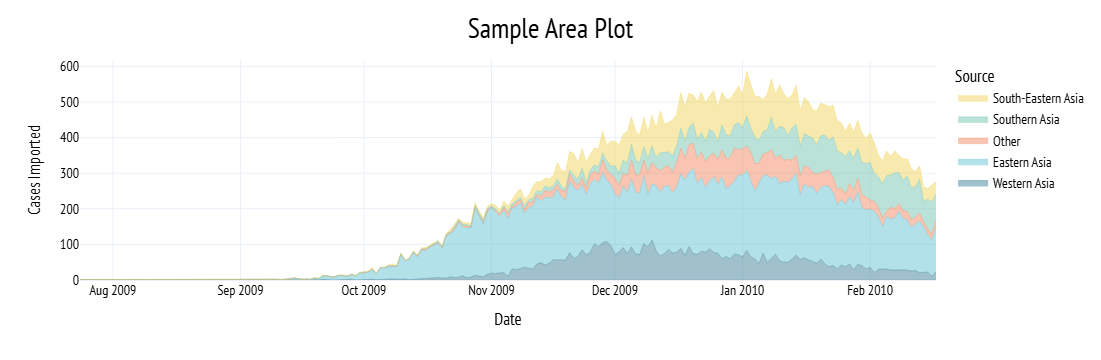

In [106]:
# Create the area plot
fig = px.area(df, x='date', y='importations', 
              color='source',
              template='netsi'
             )
fig.update_traces(line=dict(width=0.4))
fig.update_layout(title_text='Sample Area Plot', legend_traceorder='reversed',
                 xaxis_title="Date", yaxis_title="Cases Imported", legend_title_text='Source',)




fig


In [115]:
def fetch_area_plot_data(fig):
    df = pd.DataFrame()
    for trace in fig.data:
        dct = pd.DataFrame({trace.legendgroup: trace.y}, index=trace.x)
        df = pd.concat([df, dct], axis=1)

    return df

In [118]:
fetch_area_plot_data(fig).sort_index().tail()

,Western Asia,Eastern Asia,Other,Southern Asia,South-Eastern Asia
2010-02-13,21.0,144.0,23.0,95.0,38.0
2010-02-14,22.0,127.0,14.0,58.0,40.0
2010-02-15,22.0,105.0,16.0,84.0,30.0
2010-02-16,11.0,101.0,17.0,90.0,48.0
2010-02-17,24.0,124.0,21.0,72.0,35.0


Western Asia 150
Eastern Asia 170
Other 136
Southern Asia 130
South-Eastern Asia 138


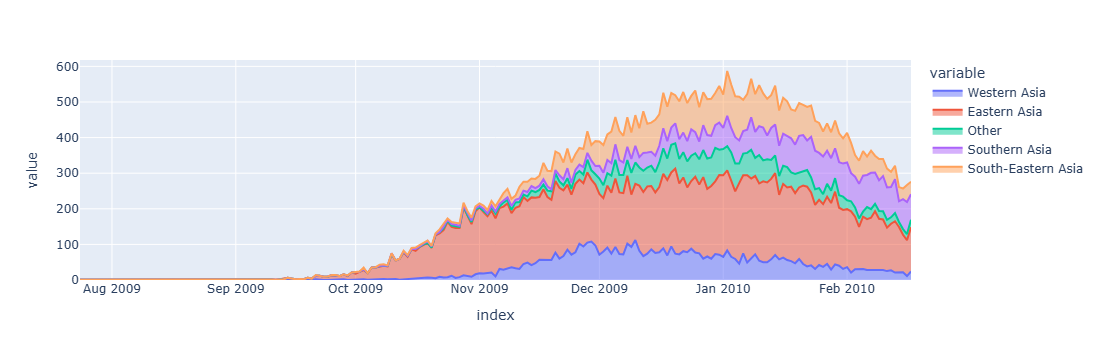

In [114]:
px.area(fetch_area_plot_data(fig))

## Sankey diagrams

In [11]:
def build_sankey_query(table_name, reference_table_name, source_geo_level, target_geo_level, source_values, target_values, date_range, 
                       cutoff=0.05, source_output_level=None, target_output_level=None, domestic=True):
                       
    if source_output_level == None:
        source_output_level = source_geo_level
    if target_output_level == None:
        target_output_level = target_geo_level
                       
    # Build filters for both source and target regions
    source_filter = build_geographic_filter(source_geo_level, source_values, alias="g_source")
    target_filter = build_geographic_filter(target_geo_level, target_values, alias="g_target")

    # Create the base where clause
    where_clauses = []

    if source_filter:
        where_clauses.append(source_filter)
    if target_filter:
        where_clauses.append(target_filter)
        
    if not domestic:
        # Exclude rows where target imports to itself
        where_clauses.append(f"g_source.{target_output_level} != g_target.{target_output_level}")

    # Join the where clauses with 'AND'
    where_clause = ' AND '.join(where_clauses)

    query = f"""
    WITH total_exportations AS (
        -- Calculate total exportations for the given date range
        SELECT 
            SUM(i.importations) AS total_sum
        FROM 
            `{table_name}` AS i
        JOIN 
            `{reference_table_name}` AS g_target 
            ON g_target.basin_id = i.target_basin
        JOIN 
            `{reference_table_name}` AS g_source 
            ON g_source.basin_id = i.source_basin
        WHERE 
            {where_clause}
            AND i.date >= '{date_range[0]}'
            AND i.date <= '{date_range[1]}'
    ), source_totals AS (
        -- Calculate total exportations for each source
        SELECT
            g_source.{source_output_level.split('_')[0]+'_id'} * -1 AS sourceid,
            g_source.{source_output_level} AS source,
            SUM(i.importations) AS source_sum
        FROM 
            `{table_name}` AS i
        JOIN 
            `{reference_table_name}` AS g_source
            ON g_source.basin_id = i.source_basin
        JOIN 
            `{reference_table_name}` AS g_target 
            ON g_target.basin_id = i.target_basin
        WHERE 
            {where_clause}
            AND i.date >= '{date_range[0]}'
            AND i.date <= '{date_range[1]}'
        GROUP BY sourceid, source
    ), target_totals AS (
        -- Calculate total exportations for each target
        SELECT
            g_target.{target_output_level.split('_')[0]+'_id'} AS targetid,
            g_target.{target_output_level} AS target,
            SUM(i.importations) AS target_sum
        FROM 
            `{table_name}` AS i
        JOIN 
            `{reference_table_name}` AS g_target
            ON g_target.basin_id = i.target_basin
        JOIN 
            `{reference_table_name}` AS g_source
            ON g_source.basin_id = i.source_basin
        WHERE 
            {where_clause}
            AND i.date >= '{date_range[0]}'
            AND i.date <= '{date_range[1]}'
        GROUP BY targetid, target
    ), categorized_sources AS (
        -- Categorize sources contributing less than the cutoff as "Other"
        SELECT 
            st.sourceid,
            CASE 
                WHEN st.source_sum < {cutoff} * t.total_sum THEN -1.5
                ELSE st.sourceid
            END AS revisedsourceid,
            CASE 
                WHEN st.source_sum < {cutoff} * t.total_sum THEN 'Other'
                ELSE st.source
            END AS source
        FROM 
            source_totals st
        CROSS JOIN 
            total_exportations t
    ), categorized_targets AS (
        -- Categorize targets contributing less than the cutoff as "Other"
        SELECT 
            tt.targetid,
            CASE 
                WHEN tt.target_sum < {cutoff} * t.total_sum THEN 1.5
                ELSE tt.targetid
            END AS revisedtargetid,
            CASE 
                WHEN tt.target_sum < {cutoff} * t.total_sum THEN 'Other'
                ELSE tt.target
            END AS target
        FROM 
            target_totals tt
        CROSS JOIN 
            total_exportations t
    ), final_exportations AS (
        -- Recalculate exportations with categorized sources and targets
        SELECT
            cs.sourceid,
            cs.revisedsourceid,
            cs.source,
            ct.targetid,
            ct.revisedtargetid,
            ct.target,
            SUM(i.importations) AS region_sum
        FROM 
            `{table_name}` AS i
        JOIN 
            `{reference_table_name}` AS g_source
            ON g_source.basin_id = i.source_basin
        JOIN 
            `{reference_table_name}` AS g_target
            ON g_target.basin_id = i.target_basin
        JOIN 
            categorized_sources cs
            ON cs.sourceid = g_source.{source_output_level.split('_')[0]+'_id'} * -1
        JOIN 
            categorized_targets ct
            ON ct.targetid = g_target.{target_output_level.split('_')[0]+'_id'}
        WHERE 
            {where_clause}
            AND i.date >= '{date_range[0]}'
            AND i.date <= '{date_range[1]}'
        GROUP BY 
            cs.sourceid, 
            cs.revisedsourceid,
            cs.source, 
            ct.targetid, 
            ct.revisedtargetid,
            ct.target
    )
    -- Final query to return exportations, ensuring "Other" sources and targets are properly grouped
    SELECT
        fe.revisedsourceid AS sourceid,
        fe.source AS source,
        fe.revisedtargetid AS targetid,
        fe.target AS target,
        SUM(fe.region_sum) / (SELECT total_sum FROM total_exportations) AS exportations
    FROM 
        final_exportations fe
    GROUP BY 
        fe.revisedsourceid, 
        fe.source, 
        fe.revisedtargetid, 
        fe.target;
    """

    return query


In [12]:
build_sankey_query

<function __main__.build_sankey_query(table_name, reference_table_name, source_geo_level, target_geo_level, source_values, target_values, date_range, cutoff=0.05, source_output_level=None, target_output_level=None, domestic=True)>

In [13]:
table_name = "net-data-viz-handbook.importation_data.sir_importations_1"
reference_table_name = 'reference.gleam-geo-map'

source_geo_level = "region_label"  # This could also be "region_id" or other levels
source_values = ['Caribbean']  
source_output_level = "country_name"

target_geo_level = "continent_label"  # Could be "country_id", "region_label", etc.
target_values = ["North America", "South America"]  # Regions to filter on
target_output_level = 'country_name'

date_range = ["2009-01-01", "2010-12-31"]  # The date range for the data
cutoff = 0.05  # Threshold for categorizing regions
domestic = False

# Call the function
query = build_sankey_query(table_name, reference_table_name, source_geo_level, target_geo_level, 
                           source_values, target_values, date_range, 
                    cutoff, source_output_level=source_output_level, target_output_level=target_output_level, 
                           domestic=domestic)

df = execute(client, query)

df.tail()

,sourceid,source,targetid,target,exportations
13,-1.5,Other,35.0,Canada,0.025798
14,-105.0,Jamaica,1.5,Other,0.009646
15,-22.0,Bahamas,35.0,Canada,0.008114
16,-22.0,Bahamas,1.5,Other,0.005828
17,-170.0,Puerto Rico,35.0,Canada,0.002361


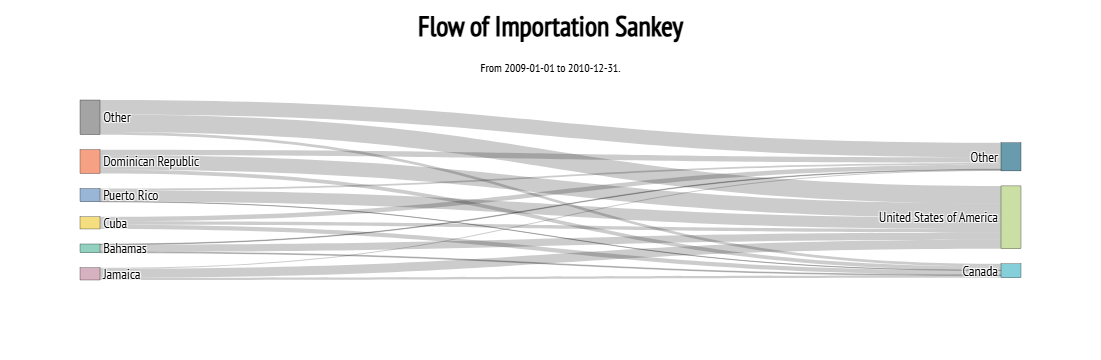

In [14]:
# Create a set of unique node IDs from both sourceid and targetid
unique_ids = set(df['sourceid']).union(set(df['targetid']))

# Create mapping for indices
dict_indices = {id_: idx for idx, id_ in enumerate(unique_ids)}

# Create mapping for labels (using the first occurrence of each name)
name_mapping = {}
for idx, row in df.iterrows():
    name_mapping[row['sourceid']] = row['source']
    name_mapping[row['targetid']] = row['target']

# Generate source, target, and value lists for the Sankey diagram
source = df['sourceid'].map(dict_indices)
target = df['targetid'].map(dict_indices)
value = df['exportations']

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.3),
        label=[name_mapping[id_] for id_ in dict_indices.keys()],  # Use names as node labels
    ),
    link=dict(
        source=source,  # Use mapped source indices
        target=target,  # Use mapped target indices
        value=value,
    )
))

fig.update_layout(
    title={
        'text': f"<b>Flow of Importation Sankey</b><br>\
<span style='font-size: 12px;'>From {date_range[0]} to {date_range[1]}.</span>",
        'x': 0.5,
        'y': 0.9,
    },
    template='netsi'
)

fig.show()

In [62]:
def fetch_sankey_data(fig):
    source = fig.data[0].link.source
    target = fig.data[0].link.target
    value = fig.data[0].link.value
    df = pd.DataFrame({'source': source, 'target': target, 'value': value})
    df[['source', 'target']] = df[['source', 'target']].replace(dict(enumerate(fig.data[0].node.label)))
    return df

In [63]:
fetch_sankey_data(fig)

,source,target,value
0,Cuba,United States of America,0.032329
1,Dominican Republic,United States of America,0.137604
2,Jamaica,United States of America,0.086159
3,Bahamas,United States of America,0.069857
4,Other,United States of America,0.166164
5,Jamaica,Canada,0.020522
6,Dominican Republic,Canada,0.035795
7,Puerto Rico,United States of America,0.106958
8,Cuba,Other,0.043331
9,Puerto Rico,Other,0.017332


## Creating an relative risk plot from sankey query

In [ ]:
dfrr = df[['target', 'targetid', 'exportations']].groupby(['target', 'targetid']).sum().sort_values(
    'exportations', ascending=False).reset_index()
dfrr

In [ ]:
# are we accounting for everything?
dfrr['exportations'].sum() == 1

In [ ]:
# Create the bar chart
fig = px.bar(
    dfrr.iloc[:, :], x='exportations', y='target', orientation='h', 
    labels={
        'target': 'Target',
        'exportations': 'Relative Risk of Importation'
    },
    template='netsi'
)

# Sort y-axis by exportations with "Other" fixed at the bottom
fig.update_layout(
    yaxis={'categoryorder': 'array', 'categoryarray': ['Other'] + sorted(
        [x for x in dfrr['target'].unique() if x != 'Other'],
        key=lambda target: dfrr.loc[dfrr['target'] == target, 'exportations'].sum(),
        reverse=False
    )},
    title={
        'text': f"Relative Risk of Importation Chart",
        'x': 0.5,
        'y': .95,
    },
    showlegend=False,
)

fig.show()


```
table_name = "net-data-viz-handbook.importation_data.sir_importations_1"
reference_table_name

source_geo_level = "region_label" 
source_values = ['Western Europe', 'Northern Europe']  
source_output_level = "country_name"

target_geo_level = "continent_label" 
target_values = ["North America"]
target_output_level = 'country_name'

date_range = ["2009-01-01", "2010-12-31"]  # The date range for the data
cutoff = 0.05  # Threshold for categorizing regions
domestic = False
```